# Reducción de la dimensionalidad (datos de motor de laminación)

*Ignacio Díaz Blanco, 2019. Universidad de Oviedo*

En este ejemplo se aplican dos técnicas de reducción de la dimensionalidad
* *Análisis de componentes principales (PCA)*, técnica lineal que implica la proyección de los datos sobre un hiperplano (en este caso 2D) definido por los vectores principales (principales direcciones de variabilidad de los datos).
* *t-stochastic neighbor embedding (t-SNE)*, es una técnica no lineal, que permite obtener un conjunto de puntos en un espacio latente de baja dimensión (en este caso 2D) de forma que, probabilísticamente, preserven las relaciones de vecindad entre ellos

Las técnicas de reducción de la dimensionalidad detectan la estructura latente de baja dimensión en el espacio de los datos lo que les permite obtener una representación de los datos multidimensionales empleando un número reducido de variables latentes sin pérdida significativa de información. 

Si se elige un número convenientemente reducido de variables latentes (2 o 3) es posible representar visualmente el proceso mediante dichas variables, creando de esta manera *mapas* del proceso que permitern interpretarlo.

En este ejemplo, se incluye una extracción de 4 características a partir de las corrientes de inducido de un motor de laminación que son proyectadas mediante PCA y tSNE en espacios latentes de 2D y posteriormente visualizadas, mostrando los distintos estados del proceso (regeneración, laminación, etc.)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.matlab import loadmat


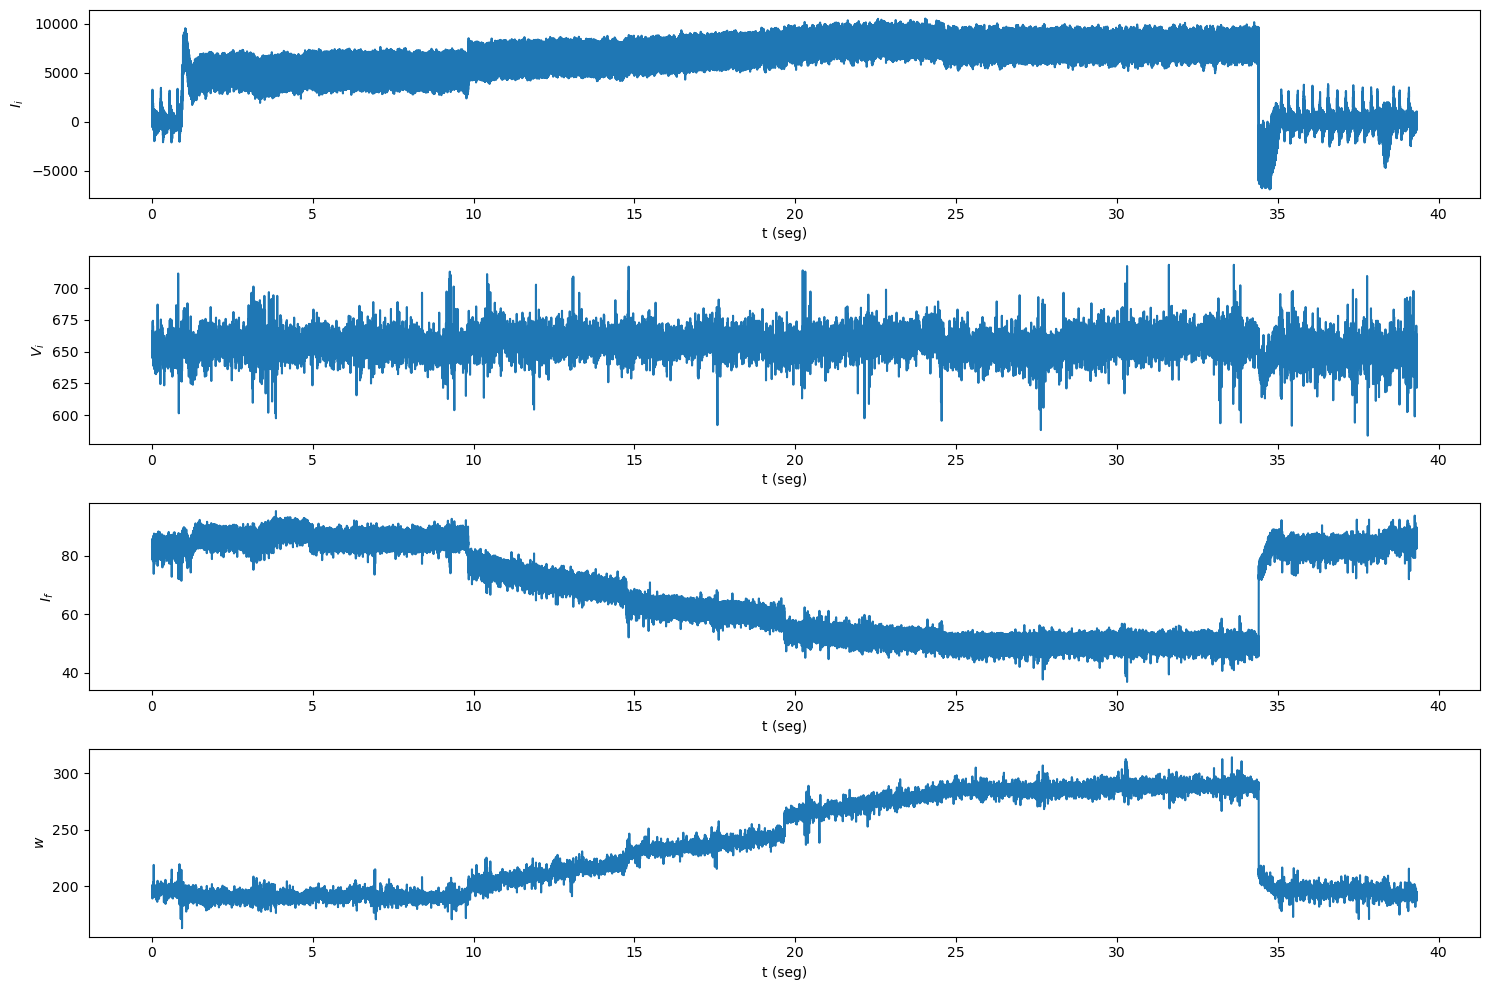

In [2]:
datos = loadmat('../../datos/datosmotorlaminacion.mat')

fm = 5000       # Frecuencia de muestreo
tm = 1/fm       # Periodo de muestreo


varNames = [i[0] for i in datos['nombres'][0]]


# OBTENEMOS INFORMACIÓN DE LOS DATOS IMPORTADOS
p = datos['p']       # matriz de datos (4 filas, muchas columnas)
Q = p.shape[1]       # tamaño de la muestra
N = 1000             # tamaño de las ventanas en la extracción de características
L = 300              # solapamiento entre ventanas en la extracción de características
t = np.arange(Q)*tm     # vector de tiempos 

# TRAZAMOS LAS VARIABLES
plt.figure(1,figsize=(15,10))
for k in range(4):
    plt.subplot(4,1,k+1)
    plt.plot(t,p[k,:])
    plt.ylabel("$"+varNames[k]+"$")
    plt.xlabel('t (seg)')
plt.tight_layout()

## Extracción de características

* Realizamos un enventanado, con ventanas de tamaño *N* solapadas, separadas *L* muestras entre ellas 
* para cada ventana, obtenemos 4 características: la media, la desviación típica, la fracción de muestras para las que la corriente de inducido $I_a$ supera 0.5 p.u y el valor RMS de la banda $300 \pm 20$ Hz

In [3]:
# extraeremos características de la corriente de inducido
y = p[0,:]


tF= []    # lista de tiempos para las características
F = []    # lista con las características por ventanas

i = 0
for k in range(N,Q,L):       # desde N hasta Q, a saltos de L en L...
    yv = y[k-N:k]/9000        
    Y  = np.abs(np.fft.fft(yv))**2/N
    f = np.arange(0,fm,fm/N)
    idx = np.where((f>280)&(f<320))
    F.append([
        np.mean(yv),
        np.std(yv),
        np.sum(yv>0.5)/float(N),
        np.sqrt(sum(2*Y[idx])/float(N))])
    tF.append(k*tm)
    i = i + 1
X = np.array(F)
tX= np.array(tF)

# Etiquetas de las características recién obtenidas
nombresCaracteristicas = [
    'media $I_a$', 
    'desv. típica $I_a$',
    'fracción > 0.5 p.u.', 
    'RMS  en banda $300 \pm 20$ Hz']

## Normalización de variables
Normalizamos las variables a $\pm 1$

In [4]:
# NORMALIZACIÓN DE LAS VARIABLES
from sklearn.preprocessing import MinMaxScaler

# Creamos una clase de normalización
minmaxx = MinMaxScaler(feature_range=(-1,1))

# Aplicamos método fit para calcular la normalización (hallar máximos y mínimos)
minmaxx.fit(X)

Xnorm = minmaxx.transform(X)


## Proyección PCA
Proyectamos los datos en el plano definido por los vectores principales y que atraviesa el centro de masas (vector de medias $\mu$) de los puntos

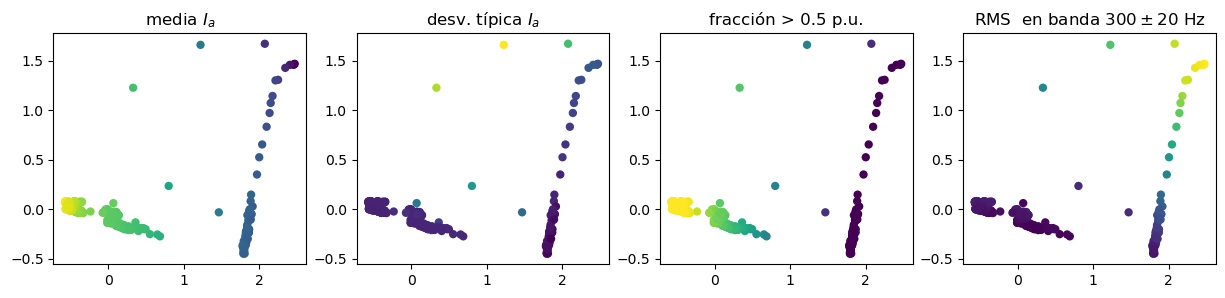

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pr = pca.fit(Xnorm).transform(Xnorm)

plt.figure(1,figsize=(15,3))

for k in range(4):
    plt.subplot(1,4,k+1)
    plt.scatter(pr[:,0],pr[:,1],c=X[:,k],linewidths=0)
    # plt.title(u'característica %d'%k)
    plt.title(nombresCaracteristicas[k])



## Proyección tSNE
Proyectamos los datos utilizando *t-stochastic Neighbor Embedding (tSNE)*, una técnica de manifold learning

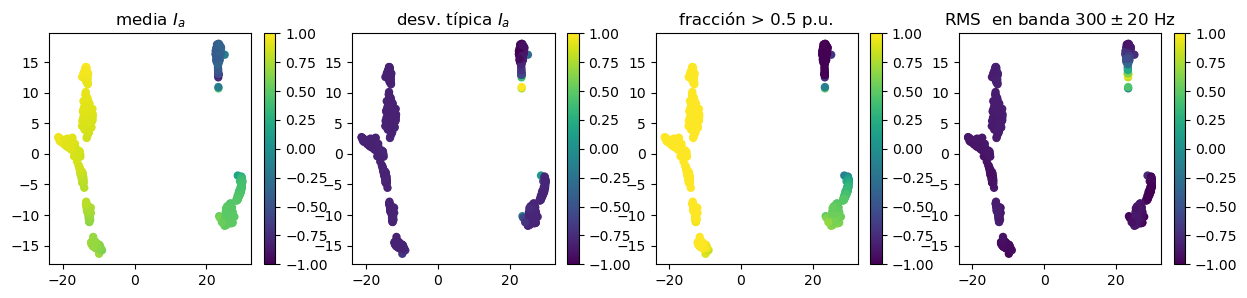

In [6]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2,perplexity=70, method='exact')

pr = tsne.fit_transform(Xnorm)

plt.figure(1,figsize=(15,3))

for k in range(4):
    plt.subplot(1,4,k+1)
    plt.scatter(pr[:,0],pr[:,1],c=Xnorm[:,k],linewidths=0)
    plt.colorbar()
    # plt.title(u'característica %d'%k)
    plt.title(nombresCaracteristicas[k])


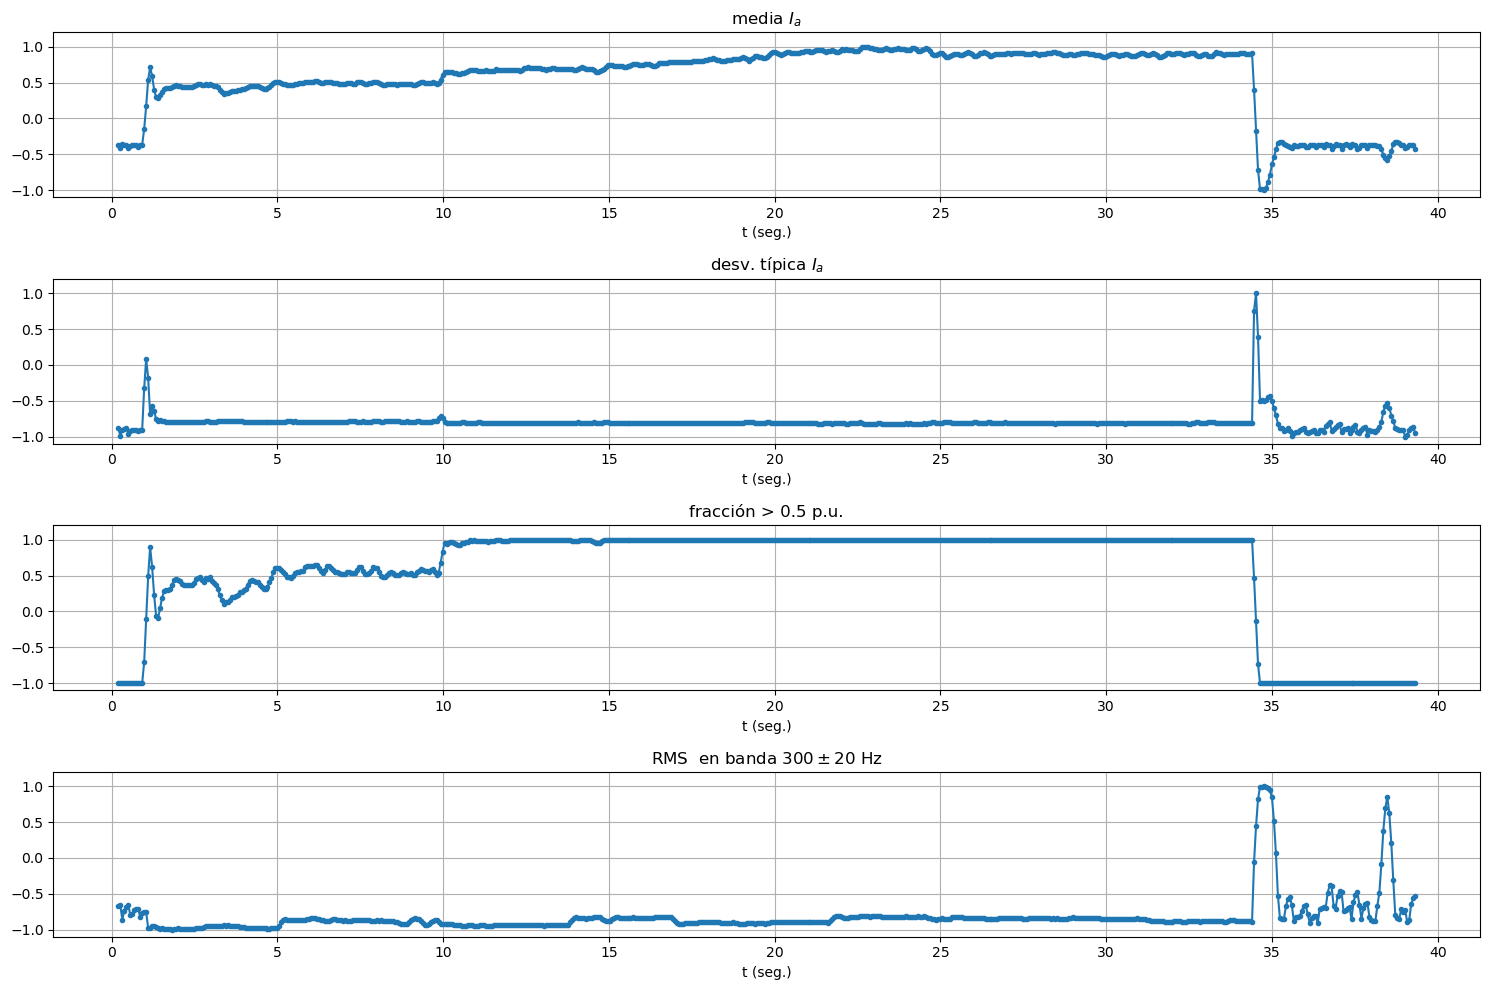

In [7]:
plt.figure(1,figsize=(15,10))
for k in range(4):
    plt.subplot(4,1,k+1)
    plt.plot(tX,Xnorm[:,k],'.-')
    plt.title(nombresCaracteristicas[k])
    plt.xlabel('t (seg.)')
    plt.grid(True)
    plt.axis(ymax=1.2)
plt.tight_layout()    

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Reducción de la dimensionalidad (datos de motor de laminación)</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://isa.uniovi.es/~idiaz" property="cc:attributionName" rel="cc:attributionURL">Ignacio Díaz Blanco</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Reconocimiento-CompartirIgual 4.0 Internacional License</a>.